In [68]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy import stats
import matplotlib.ticker as ticker
import os
from reload_recursive import reload_recursive
import patsy
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from statsmodels.miscmodels.ordinal_model import OrderedModel
from pingouin import mediation_analysis
import sys

from mri_data import file_manager as fm
import helpers

In [69]:
reload_recursive(helpers)

## Setup

In [70]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
showfigs = False
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.precision = 3
colors = helpers.get_colors()

In [71]:
df = pd.read_csv(data_dir / "t1_2_data_full.csv")

In [72]:
df = pd.read_csv(data_dir / "t1_2_data_full.csv")
df = df.set_index("subid")

df = helpers.set_dz_type5(df)
df = helpers.set_dz_type3(df)
df = helpers.set_dz_type2(df)
df = helpers.fix_edss(df)
df = helpers.clean_df(df)
df = helpers.set_has_prl(df)

keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dz_type2",
    "dz_type3",
    "dz_type5",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "DMT_score",
    "DMT_hx_all",
    "TER",
    "DMF",
    "NAT",
    "INF",
    "flair_contrast",
    "thalamus",
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "HAS_PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume", 
    "pituitary_volume"
]

df = df.loc[:, keep_cols]
df = pd.concat((df, pd.get_dummies(df["sex"], dtype="int")), axis=1)
df["Intercept"] = 1

In [73]:
df.loc[:, "lesion_vol_logtrans"] = np.log(df["lesion_vol_cubic"])
df.loc[:, "edss_sqrt"] = np.sqrt(df["EDSS"].astype("float"))
df.loc[:, "msss_sqrt"] = np.sqrt(df["MSSS"])
df.loc[:, "armss_sqrt"] = np.sqrt(df["ARMSS"])
df.loc[:, "gmsss_sqrt"] = np.sqrt(df["gMSSS"])

In [74]:
vars = [
    "age",
    "Female",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "edss_sqrt",
    "msss_sqrt",
    "armss_sqrt",
    "gmsss_sqrt",
    "DMT_score",
    "DMT_hx_all",
    "TER",
    "DMF",
    "NAT",
    "INF",
    "thalamus",
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "HAS_PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume"
]

for var in vars:
    df[var] = pd.to_numeric(df[var])

In [75]:
vars_to_center = ["edss_sqrt", "lesion_vol_logtrans", "lesion_vol_cubic", "dzdur", "choroid_volume", "PRL"]

for var in vars_to_center:
    df[f"{var}_cent"] = df[var] - df[var].mean()

centered_vars = [f"{var}_cent" for var in vars_to_center]
vars.extend(centered_vars)

In [76]:
vars_to_scale = [
    "age",
    "dzdur",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
    "thalamus"
]

df_scale = df.copy()
df_scale[vars_to_scale] = df_scale[vars_to_scale] / df_scale[vars_to_scale].mean()

In [77]:
df_ms = df.loc[df['dz_type2'] == "MS"]
df_scale_ms = df_scale.loc[df['dz_type2'] == "MS"]

df_z = df[vars].astype("float")
df_z[df.columns[~df.columns.isin(vars)]] = df[df.columns[~df.columns.isin(vars)]]
df_z = df_z[df.columns]
df_z[vars] = df_z[vars].apply(stats.zscore, nan_policy="omit")

data = df[vars].astype("float")
data_z = data[vars].apply(stats.zscore, nan_policy="omit")

data_ms = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
data_ms = data_ms[vars].astype("float")
data_ms_z = data_ms[vars].apply(stats.zscore, nan_policy="omit")

## Analysis

### Choroid Volumes

CP volume increased with age (β=0.38, p<0.001), TIV (β=0.16, p=0.001), and was smaller in females (β=-0.15, p=0.002), but was not associated with the presence of MS (β=0.18, p=0.10)

In [42]:
model_data = df_z[df_z['dz_type2'].isin(["MS", "!MS"])]
res = sm.OLS.from_formula(
    "choroid_volume ~ dz_type2 + age + tiv + Female", data=model_data
).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.214
R2_adj: 0.208
                 coef          p
Intercept      -0.076  4.643e-01
dz_type2[T.MS]  0.096  3.954e-01
age             0.375  3.149e-18
tiv             0.145  3.418e-03
Female         -0.142  4.487e-03


Within the population of MS patients, those with PMS had greater CP volumes than those with RMS, after controlling for age, sex, and TIV (β=0.36, p=0.003). 

In [61]:
model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("choroid_volume ~ dz_type5 + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.254
R2_adj: 0.246
                  coef          p
Intercept        0.315  3.054e-03
dz_type5[T.RMS] -0.359  3.329e-03
Female          -0.163  2.374e-03
age              0.321  8.375e-11
tiv              0.135  1.163e-02


In a multivariable regression controlling for age, sex, and TIV, CP volume increased with WM lesion volume (β=0.21, p<0.001) and number of PRL lesions (β=0.16, p<0.001). There was still a significant positive association with PMS (β=0.27. p=0.019)

In [62]:
model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("choroid_volume ~ lesion_vol_cubic + PRL + dz_type5 + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.334
R2_adj: 0.325
                   coef          p
Intercept         0.221  3.096e-02
dz_type5[T.RMS]  -0.274  1.941e-02
lesion_vol_cubic  0.212  4.608e-06
PRL               0.163  7.904e-05
Female           -0.166  1.138e-03
age               0.322  1.199e-10
tiv               0.109  3.141e-02


An ANCOVA was conducted to examine differences in CP volume amongst the RMS, PMS, OIND, and NIND groups, controlling for age, sex, and TIV. The analysis revealed a significant main effect for disease phenotype on CP volume (p < 0.001). Post hoc Tukey's HSD comparisons indicated that PMS had significantly larger CP than both NIND (p=0.043, d=0.51) and RMS (p=0.011, d=0.42). Additionally, sex (p<0.001), age (p<0.001), and TIV (p=0.006) were significant covariates. 

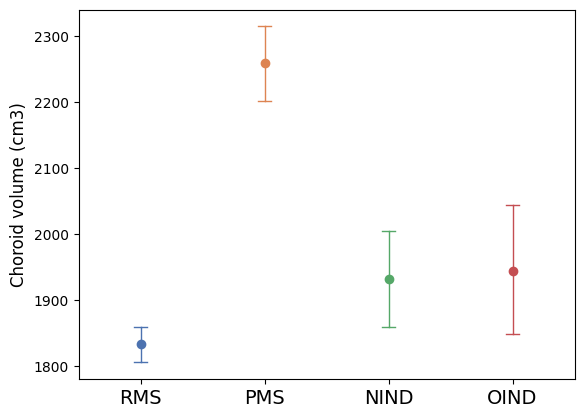

In [48]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS", "NIND", "OIND"])]

res = sm.OLS.from_formula("choroid_volume ~ dz_type5 + Female + age + tiv + lesion_vol_cubic + DMT_hx_all", data=model_data).fit()
# Extract marginal means (using 'Group')
marginal_means = res.predict(model_data[['Female', 'age', 'tiv', 'dz_type5', 'lesion_vol_cubic', 'DMT_hx_all']].drop_duplicates())

f = plt.figure()
ax = sns.pointplot(x='dz_type5', y=marginal_means, data=model_data, 
              palette='deep', hue='dz_type5', legend=False, markers='o', linestyles='-', color='red', 
              capsize=0.1, markersize=5, markeredgewidth=2, linewidth=1)
ax.set_ylabel("Choroid volume (cm3)", fontsize=12)
ax.set_xlabel("")
ax.set_xticks(["RMS", "PMS", "NIND", "OIND"])
ax.set_xticklabels(["RMS", "PMS", "NIND", "OIND"], fontsize=14)
f.patch.set_alpha(0)

See how ChP volume changes with various imaging findings

In [46]:
model_data = df_z.copy()
outcomes = ["lesion_vol_cubic", "PRL", "thalamus", "brain", "grey", "white", "cortical_thickness"]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

for outcome in outcomes:
    formula = f"{outcome} ~ choroid_volume + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[outcome] = res.pvalues['choroid_volume']
    coefs[outcome] = res.params['choroid_volume']

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
print(regression_results)

                     coef      pvals      p_fdr
lesion_vol_cubic    0.216  1.156e-05  1.156e-05
PRL                 0.250  3.606e-07  5.049e-07
thalamus           -0.371  1.282e-18  8.973e-18
brain              -0.283  1.278e-10  2.981e-10
grey               -0.204  1.272e-06  1.484e-06
white              -0.306  6.406e-11  2.242e-10
cortical_thickness -0.274  1.917e-10  3.355e-10


In [78]:
moderation_model = sm.OLS.from_formula("thalamus ~ choroid_volume*lesion_vol_cubic + tiv + age + Female", data=data_ms_z)
res = moderation_model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.494
R2_adj: 0.487
                                  coef      p
Intercept                        0.020  0.589
choroid_volume                  -0.288  0.000
lesion_vol_cubic                -0.327  0.000
choroid_volume:lesion_vol_cubic -0.067  0.068
tiv                              0.006  0.895
age                             -0.284  0.000
Female                           0.129  0.003


In [79]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               thalamus   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     65.93
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           6.05e-57
Time:                        13:06:37   Log-Likelihood:                -444.23
No. Observations:                 412   AIC:                             902.5
Df Residuals:                     405   BIC:                             930.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

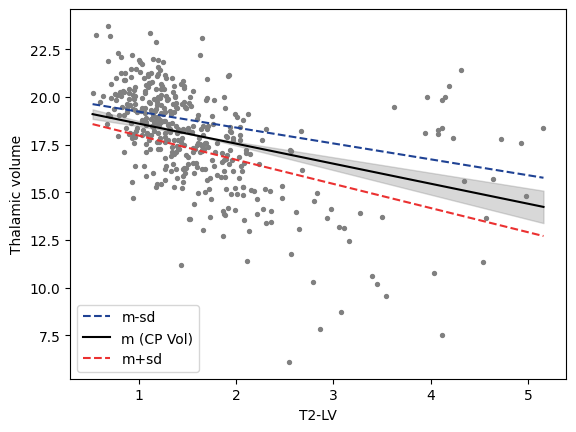

In [80]:
model_data = df.copy()
model_data = model_data[model_data['dz_type2'] == "MS"]

moderation_model = sm.OLS.from_formula("thalamus ~ choroid_volume_cent*lesion_vol_cubic_cent + tiv + age + Female", data=model_data)
res = moderation_model.fit()

x_rng, y_lvls = helpers.moderation_y(model_data, res, "lesion_vol_cubic_cent", "choroid_volume_cent")
# fix x_rng since the moderation_y took the centered version
x_rng = np.linspace(model_data['lesion_vol_cubic'].min(), model_data['lesion_vol_cubic'].max(), 100)

# helpers.plot_moderation(model_data['dzdur'], model_data['EDSS'], x_rng, y_lvls)
plt.scatter(model_data['lesion_vol_cubic'], model_data['thalamus'], s=8, color="gray")

# m-sd line
plt.plot(x_rng, y_lvls[0][0], label="m-sd", linestyle="--", color=colors['dark blue1'])
# plt.fill_between(x_rng, y_lvls[0][1], y_lvls[0][2], color=colors['light blue1'], alpha=0.1)

plt.plot(x_rng, y_lvls[1][0], label="m (CP Vol)", linestyle="-", color="black")
plt.fill_between(x_rng, y_lvls[1][1], y_lvls[1][2], color='grey', alpha=0.3)

plt.plot(x_rng, y_lvls[2][0], label="m+sd", linestyle="--", color=colors['dark red1'])
# plt.fill_between(x_rng, y_lvls[2][1], y_lvls[2][2], color=colors['light red1'], alpha=0.1)

plt.legend()
plt.xlabel("T2-LV")
plt.ylabel("Thalamic volume")
plt.show()

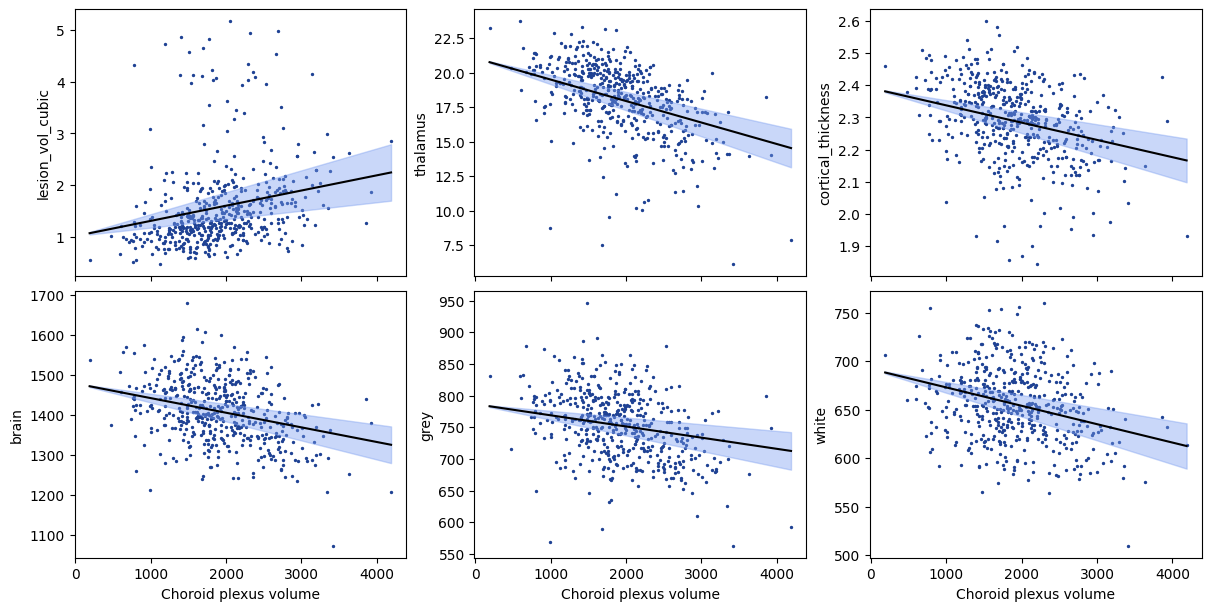

In [18]:
outcomes = ["lesion_vol_cubic", "thalamus", "brain", "grey", "white", "cortical_thickness"]
# fig, axs = plt.subplot_mosaic([['lesion_vol_cubic', 'thalamus'],
#                                ['brain', 'cortical_thickness'],
#                                ['grey', 'white']], 
#                                figsize=(8, 8),
#                                layout='constrained',
#                                )

fig, axs = plt.subplot_mosaic([['lesion_vol_cubic', 'thalamus',
                                'cortical_thickness'],
                               ['brain', 'grey', 'white']], 
                               figsize=(12, 6),
                               layout='constrained',
                               )

dark_color = colors['dark blue1']
light_color = colors['light blue1']
keep_xticks = ["brain", "grey", "white"]
for outcome in outcomes:
    formula = f"{outcome} ~ choroid_volume + {covariates}"
    res = sm.OLS.from_formula(formula, data=data).fit()
    x, y_pred, y_lims = helpers.get_regression_y(data, res, "choroid_volume", outcome)
    axs[outcome].scatter(data['choroid_volume'], data[outcome], s=2, color=dark_color)
    axs[outcome].plot(x, y_pred, color='black')
    axs[outcome].fill_between(x, y_lims[0], y_lims[1], alpha=0.4, color=light_color)
    axs[outcome].set_ylabel(outcome)
    if outcome not in keep_xticks:
        axs[outcome].set_xlabel("")
        axs[outcome].set_xticklabels([])
    else:
        axs[outcome].set_xlabel("Choroid plexus volume")

In [353]:
axs['lesion_vol_cubic'].get_ylabel()

'lesion_vol_cubic'

The best performing regression model for predicting CP volume in MS patients had an R² of 0.36 (adj R²=0.35).

In [18]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS"])]

res = sm.OLS.from_formula("choroid_volume ~ MSSS + DMT_hx_all + dz_type5 + lesion_vol_cubic + PRL", data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         choroid_volume   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     22.29
Date:                Fri, 07 Mar 2025   Prob (F-statistic):           1.53e-19
Time:                        16:44:46   Log-Likelihood:                -2937.1
No. Observations:                 376   AIC:                             5886.
Df Residuals:                     370   BIC:                             5910.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1990.2942    130.039  

### PRL Count

Choroid predicts PRL count after controlling for age, sex, tiv, and lesion volume. Show the analysis

In [19]:
mediator_model = sm.GLM.from_formula("PRL ~ lesion_vol_cubic + age + Female + tiv + choroid_volume", data=df_scale_ms, family=sm.families.Poisson())
res = mediator_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    PRL   No. Observations:                  410
Model:                            GLM   Df Residuals:                      404
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -712.54
Date:                Fri, 07 Mar 2025   Deviance:                       995.12
Time:                        16:44:46   Pearson chi2:                 1.27e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4470
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.7724      0.714  

### Clinical Disability

In [307]:
model_data = df_z.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :]

Do all the univariate regressions with age, sex, and TIV as covariates

In [170]:
predictors = ["choroid_volume", "lesion_vol_cubic", "PRL", "thalamus", "grey", "white", "cortical_thickness"]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

for predictor in predictors:
    formula = f"edss_sqrt ~ {predictor} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[predictor] = res.pvalues[predictor]
    coefs[predictor] = res.params[predictor]

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results

,coef,pvals
choroid_volume,0.101,4.306e-02
lesion_vol_cubic,0.158,5.307e-04
PRL,0.106,1.272e-02
thalamus,-0.264,1.305e-07
grey,-0.095,7.531e-02
white,-0.013,7.872e-01
cortical_thickness,-0.232,4.861e-06


Do all the univariate regressions with age, sex, TIV, and dzdur as covariates

In [335]:
predictors = ["choroid_volume", "lesion_vol_cubic", "PRL", "thalamus", "grey", "white", "cortical_thickness"]
covariates = "age + Female + tiv + dzdur + NAT + DMT_score"

pvals = {}
coefs = {}

for predictor in predictors:
    formula = f"edss_sqrt ~ {predictor} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[predictor] = res.pvalues[predictor]
    coefs[predictor] = res.params[predictor]

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results

,coef,pvals
choroid_volume,0.069,1.666e-01
lesion_vol_cubic,0.132,3.920e-03
PRL,0.108,1.038e-02
thalamus,-0.228,5.000e-06
grey,-0.097,6.519e-02
white,-0.001,9.762e-01
cortical_thickness,-0.209,3.398e-05


In [330]:
model_data['INF'].unique()

array([-0.27674254,  3.61346688])

#### EDSS and ChP Volume

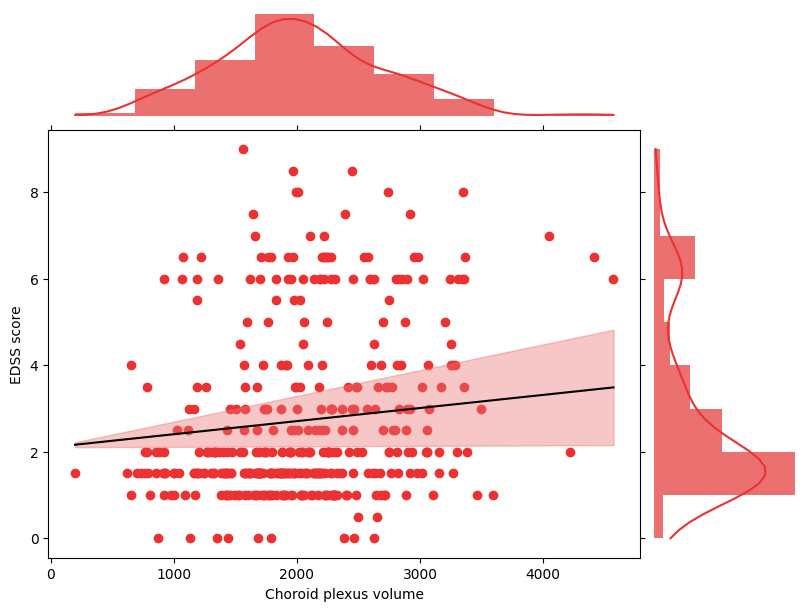

In [138]:
res = sm.OLS.from_formula("EDSS ~ choroid_volume + tiv + age + Female", data=data_ms).fit()
x, y_pred, y_lims = helpers.get_regression_y(data_ms, res, "choroid_volume", "EDSS")

fig, axs = plt.subplot_mosaic([['histx', '.'],
                               ['scatter', 'histy']],
                              figsize=(8, 6),
                              width_ratios=(4, 1), height_ratios=(1, 4),
                              layout='constrained')

helpers.scatter_hist(data_ms["choroid_volume"], 
                     data_ms["EDSS"], 
                     axs['scatter'], axs['histx'], axs['histy'],
                     light_color=colors['light red1'],
                     dark_color=colors['dark red1'])

axs['scatter'].plot(x, y_pred, color="black")
axs['scatter'].fill_between(x, y_lims[0], y_lims[1], alpha=0.4, color=colors["light red1"])
axs['scatter'].set_ylabel("EDSS score")
axs['scatter'].set_xlabel("Choroid plexus volume")
plt.show()

#### EDSS and T2-LV

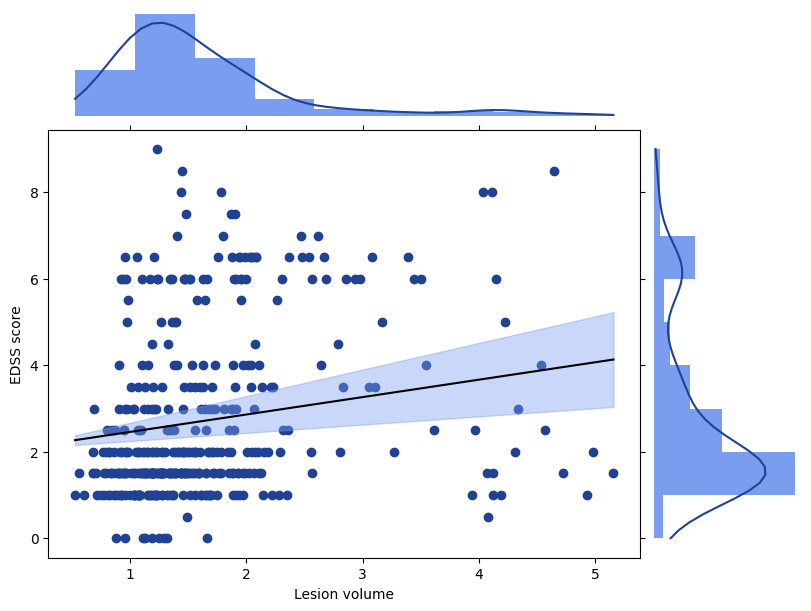

In [287]:
predictor = "lesion_vol_cubic"
formula = f"EDSS ~ {predictor} + tiv + age + Female"
res = sm.OLS.from_formula(formula, data=data_ms).fit()
x, y_pred, y_lims = helpers.get_regression_y(data_ms, res, predictor, "EDSS")

fig, axs = plt.subplot_mosaic([['histx', '.'],
                               ['scatter', 'histy']],
                              figsize=(8, 6),
                              width_ratios=(4, 1), height_ratios=(1, 4),
                              layout='constrained')

helpers.scatter_hist(data_ms[predictor], 
                     data_ms["EDSS"], 
                     axs['scatter'], axs['histx'], axs['histy'],
                     light_color=colors['light blue1'],
                     dark_color=colors['dark blue1'])

axs['scatter'].plot(x, y_pred, color="black")
axs['scatter'].fill_between(x, y_lims[0], y_lims[1], alpha=0.4, color=colors["light blue1"])
axs['scatter'].set_ylabel("EDSS score")
axs['scatter'].set_xlabel("Lesion volume")
plt.show()

In [44]:
model = sm.OLS.from_formula("edss_sqrt ~ PRL + choroid_volume + tiv + age + Female", data=model_data)
res = model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.214
R2_adj: 0.203
                 coef      p
Intercept       0.981  0.021
PRL             0.027  0.031
choroid_volume  0.154  0.099
tiv            -0.449  0.221
age             0.896  0.000
Female         -0.066  0.390


In [39]:
model = sm.OLS.from_formula("edss_sqrt ~ choroid_volume + lesion_vol_cubic + PRL + tiv + age + Female", data=model_data)
res = model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.249
R2_adj: 0.237
                   coef      p
Intercept        -0.001  0.978
choroid_volume    0.036  0.490
lesion_vol_cubic  0.138  0.005
PRL               0.073  0.095
tiv              -0.072  0.178
age               0.416  0.000
Female           -0.069  0.194


#### Mediation Analysis

##### Lesion volume mediating effect of CP volume on EDSS

In [47]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + lesion_vol_logtrans + age + tiv + Female", data=df_scale_ms
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ choroid_volume + age + tiv + Female", data=df_scale_ms
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "lesion_vol_logtrans"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.105,0.040,0.182,0.00
ACME (treated),0.105,0.040,0.182,0.00
ADE (control),0.068,-0.107,0.234,0.42
ADE (treated),0.068,-0.107,0.234,0.42
Total effect,0.173,0.006,0.325,0.04
Prop. mediated (control),0.582,0.081,4.606,0.04
Prop. mediated (treated),0.582,0.081,4.606,0.04
ACME (average),0.105,0.040,0.182,0.00
ADE (average),0.068,-0.107,0.234,0.42
Prop. mediated (average),0.582,0.081,4.606,0.04


Thalamus mediating effect of lesion volume on EDSS

In [101]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ lesion_vol_cubic + thalamus + age + tiv + Female", data=df_scale_ms
)
mediator_model = sm.OLS.from_formula(
    "thalamus ~ lesion_vol_cubic + age + tiv + Female", data=df_scale_ms
)

med = Mediation(
    outcome_model, mediator_model, "lesion_vol_cubic", "thalamus"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.104,0.046,0.169,0.000
ACME (treated),0.104,0.046,0.169,0.000
ADE (control),0.069,-0.032,0.200,0.206
ADE (treated),0.069,-0.032,0.200,0.206
Total effect,0.172,0.075,0.293,0.000
Prop. mediated (control),0.614,0.238,1.404,0.000
Prop. mediated (treated),0.614,0.238,1.404,0.000
ACME (average),0.104,0.046,0.169,0.000
ADE (average),0.069,-0.032,0.200,0.206
Prop. mediated (average),0.614,0.238,1.404,0.000


Thalamus mediating effect of choroid volume on EDSS. ACME is significant, but not prop mediated

In [123]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + thalamus + age + tiv + Female", data=df_scale_ms
)
mediator_model = sm.OLS.from_formula(
    "thalamus ~ choroid_volume + age + tiv + Female", data=df_scale_ms
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "thalamus"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.230,0.129,0.344,0.000
ACME (treated),0.230,0.129,0.344,0.000
ADE (control),-0.053,-0.262,0.152,0.630
ADE (treated),-0.053,-0.262,0.152,0.630
Total effect,0.176,-0.004,0.360,0.056
Prop. mediated (control),1.222,-3.129,7.491,0.056
Prop. mediated (treated),1.222,-3.129,7.491,0.056
ACME (average),0.230,0.129,0.344,0.000
ADE (average),-0.053,-0.262,0.152,0.630
Prop. mediated (average),1.222,-3.129,7.491,0.056


PRL mediating effect of choroid volume on EDSS. ACME is significant but not prop mediated

In [48]:
model_data = df_scale_ms.dropna()
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + PRL + age + tiv + Female", data=model_data
)
mediator_model = sm.GLM.from_formula(
    "PRL ~ choroid_volume + age + tiv + Female", data=model_data, family=sm.families.Poisson()
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "PRL"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.023,0.004,0.047,0.014
ACME (treated),0.023,0.004,0.047,0.014
ADE (control),0.153,-0.035,0.317,0.114
ADE (treated),0.153,-0.035,0.317,0.114
Total effect,0.176,-0.009,0.340,0.068
Prop. mediated (control),0.117,-0.627,0.925,0.082
Prop. mediated (treated),0.117,-0.627,0.925,0.082
ACME (average),0.023,0.004,0.047,0.014
ADE (average),0.153,-0.035,0.317,0.114
Prop. mediated (average),0.117,-0.627,0.925,0.082


Lesion volume mediating effect of PRL count on EDSS. There is a significant effect, but don't think it describes anything interesting (ie more PRL mean greater lesion volume which is related to EDSS)

In [49]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ PRL + lesion_vol_logtrans + age + tiv + Female", data=df_scale_ms
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ PRL + age + tiv + Female", data=df_scale_ms
)

med = Mediation(
    outcome_model, mediator_model, "PRL", "lesion_vol_logtrans"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.011,-9.843e-04,0.027,0.084
ACME (treated),0.011,-9.843e-04,0.027,0.084
ADE (control),0.019,-1.710e-03,0.042,0.074
ADE (treated),0.019,-1.710e-03,0.042,0.074
Total effect,0.030,6.987e-03,0.054,0.008
Prop. mediated (control),0.366,-1.114e-01,1.123,0.092
Prop. mediated (treated),0.366,-1.114e-01,1.123,0.092
ACME (average),0.011,-9.843e-04,0.027,0.084
ADE (average),0.019,-1.710e-03,0.042,0.074
Prop. mediated (average),0.366,-1.114e-01,1.123,0.092


Significant effect, but same interpretation as above

In [42]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ lesion_count + lesion_vol_logtrans + age + tiv + Female", data=df_scale_ms
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ lesion_count + age + tiv + Female", data=df_scale_ms
)

med = Mediation(
    outcome_model, mediator_model, "lesion_count", "lesion_vol_logtrans"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.082,0.040,0.126,0.00
ACME (treated),0.082,0.040,0.126,0.00
ADE (control),-0.044,-0.101,0.008,0.11
ADE (treated),-0.044,-0.101,0.008,0.11
Total effect,0.038,-0.007,0.084,0.09
Prop. mediated (control),2.030,-7.752,15.064,0.09
Prop. mediated (treated),2.030,-7.752,15.064,0.09
ACME (average),0.082,0.040,0.126,0.00
ADE (average),-0.044,-0.101,0.008,0.11
Prop. mediated (average),2.030,-7.752,15.064,0.09


In [43]:
model_data = df_scale_ms.dropna()
outcome_model = sm.OLS.from_formula("edss_sqrt ~ lesion_count + PRL + age + Female + tiv", data=model_data)
# print(outcome_model.fit().summary())

mediator_model = sm.GLM.from_formula("PRL ~ lesion_count + age + Female + tiv", data=model_data, family=sm.families.Poisson())
# print(mediator_model.fit().summary())

med = Mediation(
    outcome_model, mediator_model, "lesion_count", "PRL"
).fit()
print(med.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)               0.004      -9.071e-04           0.011    0.116
ACME (treated)               0.004      -9.071e-04           0.011    0.116
ADE (control)                0.042       1.933e-03           0.085    0.044
ADE (treated)                0.042       1.933e-03           0.085    0.044
Total effect                 0.046       6.342e-03           0.089    0.022
Prop. mediated (control)     0.077      -4.396e-02           0.507    0.134
Prop. mediated (treated)     0.077      -4.396e-02           0.507    0.134
ACME (average)               0.004      -9.071e-04           0.011    0.114
ADE (average)                0.042       1.933e-03           0.085    0.044
Prop. mediated (average)     0.077      -4.396e-02           0.507    0.132


#### Moderation 

In [404]:
model_data = df_z.copy()
model_data = model_data[model_data['dz_type2'] == "MS"]

moderation_model = sm.OLS.from_formula("EDSS ~ dzdur + lesion_vol_cubic + tiv + age + Female", data=model_data)
res = moderation_model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.264
R2_adj: 0.255
                   coef      p
Intercept        -0.003  0.954
dzdur             0.248  0.000
lesion_vol_cubic  0.143  0.002
tiv              -0.057  0.289
age               0.241  0.000
Female           -0.111  0.034


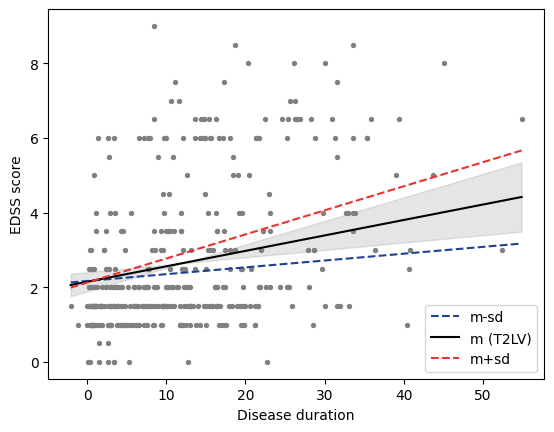

In [504]:
model_data = df.copy()
model_data = model_data[model_data['dz_type2'] == "MS"]

moderation_model = sm.OLS.from_formula("EDSS ~ dzdur_cent*lesion_vol_cubic_cent + tiv + age + Female", data=model_data)
res = moderation_model.fit()

x_rng, y_lvls = helpers.moderation_y(model_data, res, "dzdur_cent", "lesion_vol_cubic_cent")
# fix x_rng since the moderation_y took the centered version
x_rng = np.linspace(model_data['dzdur'].min(), model_data['dzdur'].max(), 100)

# helpers.plot_moderation(model_data['dzdur'], model_data['EDSS'], x_rng, y_lvls)
plt.scatter(model_data['dzdur'], model_data['EDSS'], s=8, color="gray")

# m-sd line
plt.plot(x_rng, y_lvls[0][0], label="m-sd", linestyle="--", color=colors['dark blue1'])
# plt.fill_between(x_rng, y_lvls[0][1], y_lvls[0][2], color=colors['light blue1'], alpha=0.1)

plt.plot(x_rng, y_lvls[1][0], label="m (T2LV)", linestyle="-", color="black")
plt.fill_between(x_rng, y_lvls[1][1], y_lvls[1][2], color='grey', alpha=0.2)

plt.plot(x_rng, y_lvls[2][0], label="m+sd", linestyle="--", color=colors['dark red1'])
# plt.fill_between(x_rng, y_lvls[2][1], y_lvls[2][2], color=colors['light red1'], alpha=0.1)

plt.legend()
plt.xlabel("Disease duration")
plt.ylabel("EDSS score")
plt.show()

There is a significant interaction of CP volume and lesion volume on EDSS. But don't know how to interpret this alongside the mediation analysis. Also R2 improves when including both as an interaction instead of separate terms

Chris was explaining how lesion volume and ChP volume may be indicators of different sources of inflammation (leptomeningeal inflammation, cortical inflammation, or subcortical inflammation?). The interaction term being multiplicative could be related to the multiplicative effects of both types of inflammation

In which case, the mediation model is testing a different possibly competing model 

In [82]:
moderation_model = sm.OLS.from_formula("EDSS ~ choroid_volume*lesion_vol_cubic + tiv + age + Female", data=df_z)
res = moderation_model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.218
R2_adj: 0.207
                                  coef      p
Intercept                       -0.052  0.242
choroid_volume                  -0.012  0.813
lesion_vol_cubic                 0.166  0.000
choroid_volume:lesion_vol_cubic  0.103  0.020
tiv                             -0.079  0.125
age                              0.377  0.000
Female                          -0.106  0.038


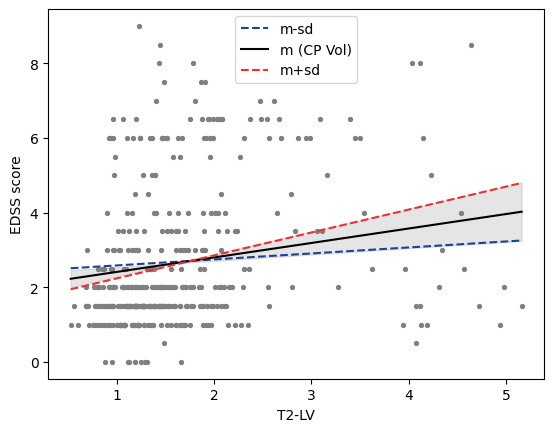

In [83]:
moderation_model = sm.OLS.from_formula("EDSS ~ choroid_volume_cent*lesion_vol_cubic_cent + tiv + age + Female", data=model_data)
res = moderation_model.fit()

x_rng, y_lvls = helpers.moderation_y(model_data, res, "lesion_vol_cubic_cent", "choroid_volume_cent")
# fix x_rng since the moderation_y took the centered version
x_rng = np.linspace(model_data['lesion_vol_cubic'].min(), model_data['lesion_vol_cubic'].max(), 100)

# helpers.plot_moderation(model_data['dzdur'], model_data['EDSS'], x_rng, y_lvls)
plt.scatter(model_data['lesion_vol_cubic'], model_data['EDSS'], s=8, color="gray")

# m-sd line
plt.plot(x_rng, y_lvls[0][0], label="m-sd", linestyle="--", color=colors['dark blue1'])
# plt.fill_between(x_rng, y_lvls[0][1], y_lvls[0][2], color=colors['light blue1'], alpha=0.1)

plt.plot(x_rng, y_lvls[1][0], label="m (CP Vol)", linestyle="-", color="black")
plt.fill_between(x_rng, y_lvls[1][1], y_lvls[1][2], color='grey', alpha=0.2)

plt.plot(x_rng, y_lvls[2][0], label="m+sd", linestyle="--", color=colors['dark red1'])
# plt.fill_between(x_rng, y_lvls[2][1], y_lvls[2][2], color=colors['light red1'], alpha=0.1)

plt.legend()
plt.xlabel("T2-LV")
plt.ylabel("EDSS score")
plt.show()

#### Ordinal Regression on EDSS

In [124]:
model_data = df_scale.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :].dropna()

mod_prob = OrderedModel.from_formula("EDSS ~ PRL + tiv + age + Female",
                                     data=model_data, distr='logit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 2.190125
         Iterations: 77
         Function evaluations: 79
         Gradient evaluations: 79


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   EDSS   Log-Likelihood:                -812.54
Model:                   OrderedModel   AIC:                             1667.
Method:            Maximum Likelihood   BIC:                             1749.
Date:                Fri, 28 Feb 2025                                         
Time:                        15:51:02                                         
No. Observations:                 371                                         
Df Residuals:                     350                                         
Df Model:                           4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PRL            0.1034      0.042      2.474      0.013       0.021       0.185
tiv           -1.3265      1.296     -1.024      0.306      -3.867       1.214
age            3.4101      0.397      8.590      0.000       2.632       4.188
Female        -0.2848      0.266     -1.069      0.285      -0.807       0.237
0.0/1.0       -2.4345      1.547     -1.574      0.116      -5.467       0.598
1.0/1.5        0.9753      0.151      6.446      0.000       0.679       1.272
1.5/2.0        0.3874      0.094      4.140      0.000       0.204       0.571
2.0/2.5       -0.3045      0.124     -2.454      0.014      -0.548      -0.061
2.5/3.0       -1.3054      0.218     -5.997      0.000      -1.732      -0.879
3.0/3.5       -1.1684      0.207     -5.648      0.000      -1.574      -0.763
3.5/4.0       -1.2278      0.223     -5.499      0.000      -1.665      -0.790
4.0/4.5       -1.2832      0.244     -5.261      0.000      -1.761      -0.805
4.5/5.0       -2.5982      0.497     -5.232      0.000      -3.572      -1.625
5.0/5.5       -1.9922      0.374     -5.332      0.000      -2.725      -1.260
5.5/6.0       -2.4942      0.497     -5.022      0.000      -3.468      -1.521
6.0/6.5       -0.2007      0.176     -1.138      0.255      -0.546       0.145
6.5/7.0        0.0030      0.228      0.013      0.990      -0.444       0.450
7.0/7.5       -0.9465      0.498     -1.899      0.058      -1.923       0.030
7.5/8.0       -0.8638      0.577     -1.497      0.135      -1.995       0.267
8.0/8.5       -0.3410      0.584     -0.584      0.560      -1.487       0.804
8.5/9.0        0.1048      0.740      0.142      0.887      -1.345       1.554
==============================================================================
"""

#### MSSS

In [20]:
model = sm.OLS.from_formula("msss_sqrt ~ tiv + Female + lesion_vol_cubic + choroid_volume", data=df_scale)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              msss_sqrt   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.268
Date:                Sat, 22 Feb 2025   Prob (F-statistic):             0.0613
Time:                        16:36:36   Log-Likelihood:                -417.23
No. Observations:                 403   AIC:                             844.5
Df Residuals:                     398   BIC:                             864.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.5095      0.522  

#### ARMSS

In [21]:
model = sm.OLS.from_formula("armss_sqrt ~ choroid_volume + tiv + Female + age", data=df_scale)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             armss_sqrt   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.939
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           3.49e-06
Time:                        16:36:50   Log-Likelihood:                -412.59
No. Observations:                 440   AIC:                             835.2
Df Residuals:                     435   BIC:                             855.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0896      0.480      6.

### Mediation

In [427]:
model = sm.OLS.from_formula("edss_sqrt ~ thalamus + lesion_vol_cubic*choroid_volume + tiv + age + Female", data=df_z)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              edss_sqrt   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     22.39
Date:                Sat, 08 Mar 2025   Prob (F-statistic):           6.96e-26
Time:                        20:49:07   Log-Likelihood:                -559.03
No. Observations:                 442   AIC:                             1134.
Df Residuals:                     434   BIC:                             1167.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [432]:
model = sm.OLS.from_formula("thalamus ~ lesion_vol_cubic*choroid_volume + tiv + age + Female", data=df_z)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               thalamus   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     87.60
Date:                Sat, 08 Mar 2025   Prob (F-statistic):           3.92e-74
Time:                        20:52:27   Log-Likelihood:                -517.52
No. Observations:                 492   AIC:                             1049.
Df Residuals:                     485   BIC:                             1078.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [81]:
p2 = Process(data=data_ms_z, model=8, x="lesion_vol_cubic", y="edss_sqrt", w="choroid_volume",
            m=["thalamus"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 8

Variables:
    Cons = Cons
    x = lesion_vol_cubic
    y = edss_sqrt
    w = choroid_volume
    m1 = thalamus
Statistical Controls:
 age, Female, tiv



Sample size:
412

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = edss_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2809   0.2661 0.7338 21.7124    7  389   0.0000

Coefficients

                                  coeff     se       t      p    LLCI    ULCI
Cons                            -0.0366 0.0451 -0.8105 0.4182 -0.1251  0.0519
lesion_vol_cubic                 0.0664 0.0494  1.3431 0.1800 -0.0305  0.1633
choroid_volume    

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

,R²,Adj. R²,MSE,F,df1,df2,p-value
,0.282,0.268,0.732,21.879,7,389,1.110e-16


In [541]:
process_output = curr_dir / "process_output"
p2.outcome_models['edss_sqrt'].model_summary().to_csv(process_output / "outcome_model_edss_summary.csv")
p2.outcome_models['thalamus'].model_summary().to_csv(process_output / "outcome_model_thal_summary.csv")
p2.outcome_models['thalamus'].coeff_summary().to_csv(process_output / "outcome_model_thal.csv")
p2.outcome_models['edss_sqrt'].coeff_summary().to_csv(process_output / "outcome_model_edss.csv")
p2.direct_model.coeff_summary().to_csv(process_output / "direct_model.csv")
p2.indirect_model.coeff_summary().to_csv(process_output / "indirect_model.csv")

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1188: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return df.apply(pd.to_numeric, args=["ignore"])


In [485]:
moderation_model = sm.OLS.from_formula("EDSS ~ choroid_volume*lesion_vol_cubic + thalamus + tiv + age + Female", data=data_ms_z)
res = moderation_model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.276
R2_adj: 0.263
                                  coef      p
Intercept                       -0.052  0.254
choroid_volume                  -0.060  0.289
lesion_vol_cubic                 0.065  0.191
choroid_volume:lesion_vol_cubic  0.105  0.018
thalamus                        -0.246  0.000
tiv                             -0.050  0.338
age                              0.329  0.000
Female                          -0.065  0.226


Notes for the moderated mediation model before:

When including thalamus and choroid:lesion_vol, the coefficient for choroid flips signs. Actually, including the thalamus at all with choroid flips the choroid sign. The choroid effect just isn't significant 

In [464]:
model_data = data_ms
model_data['choroid_volume2'] = model_data['choroid_volume'] / 1000

p2 = Process(data=model_data, model=8, x="lesion_vol_cubic", y="edss_sqrt", w="choroid_volume2",
            m=["thalamus"],
            controls=["age", "Female", "tiv"],
            controls_in="all")

# p2.summary()

orig_stdout = sys.stdout
with open("process_macro_out.txt", 'w') as f:
    sys.stdout = f
    p2.summary()
    # print(p2.summary(), file=f)
sys.stdout = orig_stdout

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 8

Variables:
    Cons = Cons
    x = lesion_vol_cubic
    y = edss_sqrt
    w = choroid_volume2
    m1 = thalamus
Statistical Controls:
 age, Female, tiv



Sample size:
412

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0


/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

In [486]:
p2 = Process(data=data_ms_z, model=8, x="lesion_vol_cubic", y="edss_sqrt", w="choroid_volume",
            m=["thalamus"],
            controls=["age", "Female", "tiv"],
            controls_in="all")

# p2.summary()

orig_stdout = sys.stdout
with open("process_macro_out2.txt", 'w') as f:
    sys.stdout = f
    p2.summary()
    # print(p2.summary(), file=f)
sys.stdout = orig_stdout

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 8

Variables:
    Cons = Cons
    x = lesion_vol_cubic
    y = edss_sqrt
    w = choroid_volume
    m1 = thalamus
Statistical Controls:
 age, Female, tiv



Sample size:
412

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0


/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


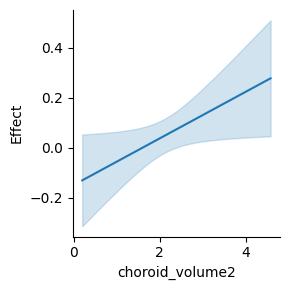

In [443]:
g = p2.plot_conditional_direct_effects(x="choroid_volume2")

In [75]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + lesion_vol_logtrans + age + tiv + Female", data=df_scale
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ choroid_volume + age + tiv + Female", data=df_scale
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "lesion_vol_logtrans"
).fit(method="bootstrap")
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.106996,0.054724,0.174995,0.000
ACME (treated),0.106996,0.054724,0.174995,0.000
ADE (control),0.067991,-0.102547,0.219749,0.426
ADE (treated),0.067991,-0.102547,0.219749,0.426
Total effect,0.174987,0.011623,0.331057,0.036
Prop. mediated (control),0.588430,0.193524,2.957493,0.036
Prop. mediated (treated),0.588430,0.193524,2.957493,0.036
ACME (average),0.106996,0.054724,0.174995,0.000
ADE (average),0.067991,-0.102547,0.219749,0.426
Prop. mediated (average),0.588430,0.193524,2.957493,0.036


PRL does not mediate the association between lesion count and EDSS

In [74]:
model_data = df_scale_ms.dropna()
outcome_model = sm.OLS.from_formula("edss_sqrt ~ lesion_count + PRL + age + Female + tiv", data=model_data)
# print(outcome_model.fit().summary())

mediator_model = sm.GLM.from_formula("PRL ~ lesion_count + age + Female + tiv", data=model_data, family=sm.families.Poisson())
# print(mediator_model.fit().summary())

med = Mediation(
    outcome_model, mediator_model, "lesion_count", "PRL"
).fit()
print(med.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.003839       -0.000646        0.010799    0.120
ACME (treated)            0.003839       -0.000646        0.010799    0.116
ADE (control)             0.042244        0.001254        0.083481    0.042
ADE (treated)             0.042244        0.001254        0.083481    0.042
Total effect              0.046083        0.005338        0.087924    0.030
Prop. mediated (control)  0.076149       -0.048580        0.438222    0.150
Prop. mediated (treated)  0.076149       -0.048580        0.438222    0.146
ACME (average)            0.003839       -0.000646        0.010799    0.120
ADE (average)             0.042244        0.001254        0.083481    0.042
Prop. mediated (average)  0.076149       -0.048580        0.438222    0.150


In [161]:
model_data = df_scale.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :].dropna()
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'])), axis=1
)
model_data['PMS'] = model_data['PMS'].astype("int64")

model = sm.GLM.from_formula("PRL ~ PMS + age + Female", data=model_data, family=sm.families.Poisson())
res = model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    PRL   No. Observations:                  371
Model:                            GLM   Df Residuals:                      367
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -677.32
Date:                Sat, 01 Mar 2025   Deviance:                       975.59
Time:                        16:05:21   Pearson chi2:                 1.40e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2707
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4501      0.216     11.368      0.0

### Predicting MS Phenotype

Logistic regression on PMS

In [160]:
model_data = df_z.loc[df_z['dz_type5'].isin(['RMS', 'PMS'])]
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'])), axis=1
)
model_data['PMS'] = model_data['PMS'].astype("int64")

# logit_mod = sm.Logit.from_formula("PMS ~ choroid_volume + lesion_vol_cubic + dzdur + age + tiv + Female", data=model_data)
logit_mod = sm.Logit.from_formula("PMS ~ PRL + age + tiv + Female", data=model_data)
res = logit_mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.379418
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    PMS   No. Observations:                  410
Model:                          Logit   Df Residuals:                      405
Method:                           MLE   Df Model:                            4
Date:                Fri, 28 Feb 2025   Pseudo R-squ.:                  0.2518
Time:                        16:07:18   Log-Likelihood:                -155.56
converged:                       True   LL-Null:                       -207.91
Covariance Type:            nonrobust   LLR p-value:                 9.854e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9558      0.190    -10.310      0.000      -2.328      -1.584
PRL            0.1270      0.

In [84]:
model_data = df_z.loc[df_z['dz_type2'].isin(['MS', '!MS'])]
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type2'])), axis=1
)
model_data['MS'] = model_data['MS'].astype("int64")

# logit_mod = sm.Logit.from_formula("PMS ~ choroid_volume + lesion_vol_cubic + dzdur + age + tiv + Female", data=model_data)
logit_mod = sm.Logit.from_formula("MS ~ choroid_volume + age + tiv + Female", data=model_data)
res = logit_mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.416241
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                     MS   No. Observations:                  487
Model:                          Logit   Df Residuals:                      482
Method:                           MLE   Df Model:                            4
Date:                Thu, 27 Feb 2025   Pseudo R-squ.:                 0.03108
Time:                        14:16:44   Log-Likelihood:                -202.71
converged:                       True   LL-Null:                       -209.21
Covariance Type:            nonrobust   LLR p-value:                   0.01126
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.7739      0.133     13.305      0.000       1.513       2.035
choroid_volume   

In [ ]:
model_data = df_z.copy()
model = sm.OLS.from_formula("edss_sqrt ~ choroid_volume + thalamus + age + Female + tiv", data=model_data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              edss_sqrt   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     28.39
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           6.27e-25
Time:                        19:26:27   Log-Likelihood:                -564.88
No. Observations:                 442   AIC:                             1142.
Df Residuals:                     436   BIC:                             1166.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0246      0

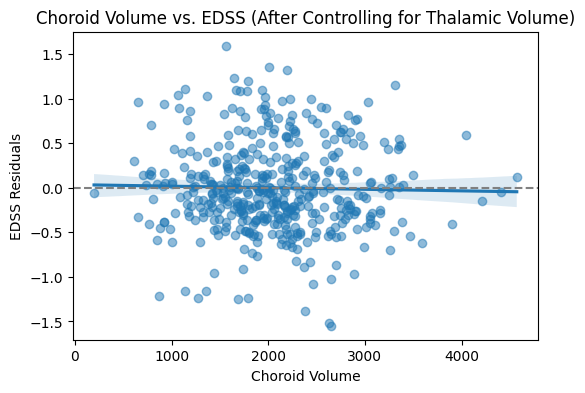

In [508]:
model_data = df.copy()
model = sm.OLS.from_formula("edss_sqrt ~ thalamus + age + Female + tiv", data=model_data).fit()
model_data['EDSS_residuals'] = model.resid

plt.figure(figsize=(6, 4))
sns.regplot(x=model_data["choroid_volume"], y=model_data["EDSS_residuals"], scatter_kws={'alpha':0.5})
plt.axhline(0, linestyle="--", color="gray")
plt.title("Choroid Volume vs. EDSS (After Controlling for Thalamic Volume)")
plt.xlabel("Choroid Volume")
plt.ylabel("EDSS Residuals")
plt.show()

In [ ]:
import statsmodels.api as sm

# Example: Regress EDSS on Thalamic Volume
X = sm.add_constant(df["Thalamus"])  # Add intercept
model = sm.OLS(df["EDSS"], X).fit()
df["EDSS_residuals"] = model.resid  # Extract residuals

# Scatter plot of Choroid Volume vs Residualized EDSS
plt.figure(figsize=(6, 4))
sns.regplot(x=df["Choroid_Volume"], y=df["EDSS_residuals"], scatter_kws={'alpha':0.5})
plt.axhline(0, linestyle="--", color="gray")
plt.title("Choroid Volume vs. EDSS (After Controlling for Thalamic Volume)")
plt.xlabel("Choroid Volume")
plt.ylabel("EDSS Residuals")
plt.show()
